In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
for table_name in inspector.get_table_names(): 
    print('===============================')
    print(table_name)
    print('===============================')
    
    for column in inspector.get_columns(table_name): 
        print(f"Column: {column['name']} TYPE: {column['type']}")


measurement
Column: id TYPE: INTEGER
Column: station TYPE: TEXT
Column: date TYPE: TEXT
Column: prcp TYPE: FLOAT
Column: tobs TYPE: FLOAT
station
Column: id TYPE: INTEGER
Column: station TYPE: TEXT
Column: name TYPE: TEXT
Column: latitude TYPE: FLOAT
Column: longitude TYPE: FLOAT
Column: elevation TYPE: FLOAT


# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23 00:00:00
('2016-08-24', 0.08)


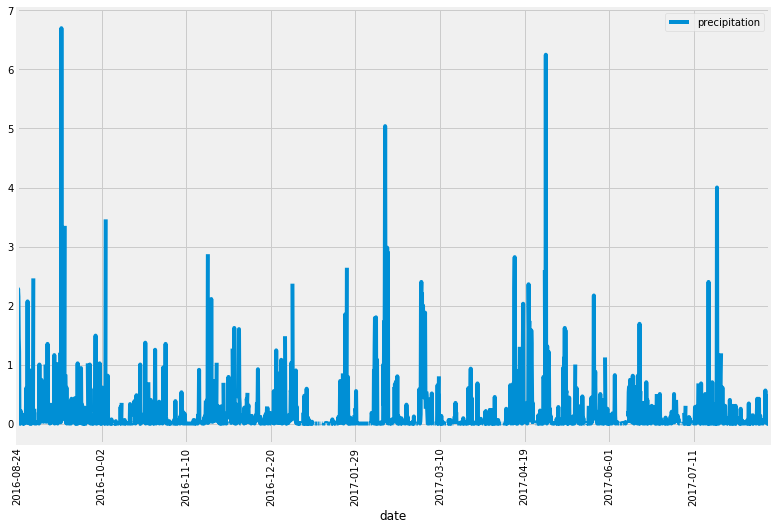

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_db_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

replace_list = "(',)"
for char in replace_list: 
    latest_db_date = str(latest_db_date).replace(char, '')
latest_db_date = dt.datetime.strptime(latest_db_date, '%Y-%m-%d')
print(latest_db_date)

# Calculate the date 1 year ago from the last data point in the database
previous_year_date = latest_db_date - dt.timedelta(days = 365)
print(previous_year_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > previous_year_date).all()
print(results[0])
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns = ["date", "precipitation"])
precipitation_df.set_index(["date"], inplace = True)


# Sort the dataframe by date
precipitation_df.sort_values("date", inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x_compat = True, rot = 90)

fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.savefig('precipitation.png', dpi=100)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(precipitation_df.describe())

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = len(session.query(Measurement.station).distinct().all())
print(number_of_stations)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, \
                              func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
for station_rec in station_counts:
    print(station_rec)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = station_counts[0][0]

most_active_station_id

temp_aggregates = session.query(func.min(Measurement.tobs), \
                                func.max(Measurement.tobs), \
                                func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == most_active_station_id).\
                                    group_by(Measurement.station).all()

temp_aggregates

[(54.0, 85.0, 71.66378066378067)]

   temperature
0         70.0
1         62.0
2         74.0
3         75.0
4         74.0


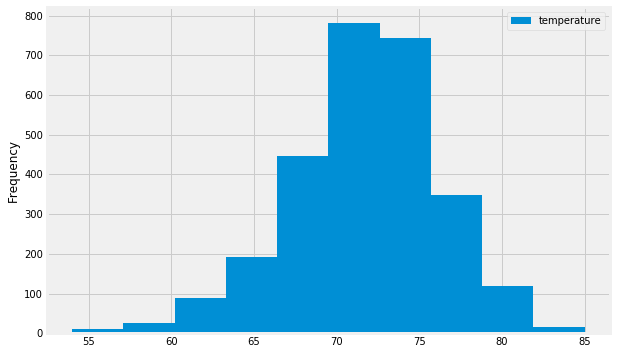

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_most_active_data = session.query(Measurement.tobs).\
                            filter(Measurement.station == most_active_station_id).all()

temp_most_active_df = pd.DataFrame(temp_most_active_data, columns = ["temperature"])

print(temp_most_active_df.head())

temp_most_active_df.plot(kind = 'hist')

fig = plt.gcf()
fig.set_size_inches(9, 6)
fig.savefig('most_active_station_distribution.png', dpi=100)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
latest_avg_temp_data = calc_temps(previous_year_date, latest_db_date)

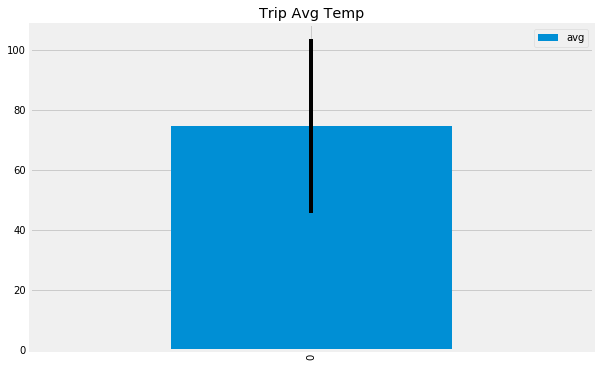

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
latest_avg_temp_df = pd.DataFrame(latest_avg_temp_data, columns = ['min', 'avg', 'max'])

latest_avg_temp_df.plot(kind = 'bar', \
                        y = 'avg', \
                        yerr = latest_avg_temp_df['max'] - latest_avg_temp_df['min'], \
                        title = 'Trip Avg Temp')

fig = plt.gcf()
fig.set_size_inches(9, 6)
fig.savefig('average_temperature.png', dpi=100)

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_prcp_max = session.query(Measurement.station, Measurement.prcp, Measurement.date, \
                                 Station.name, Station.latitude, Station.longitude, \
                                 Station.elevation).\
                                    filter(Measurement.station == Station.station).\
                                    filter(Measurement.date >= previous_year_date).\
                                    filter(Measurement.date <= latest_db_date).\
                                    group_by(Measurement.station).\
                                    order_by(Measurement.prcp.desc()).\
                                    all()
for rec in station_prcp_max: 
    print(rec)

('USC00514830', 2.28, '2016-08-24', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00513117', 2.15, '2016-08-24', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519281', 2.15, '2016-08-24', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00516128', 1.45, '2016-08-24', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519523', 1.22, '2016-08-24', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.08, '2016-08-24', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, '2016-08-24', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
